In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import fmin_slsqp
from toolz import reduce, partial
import pyfixest as pf

In [2]:
attainment = pd.read_excel("nayro.xls")
year_cols = [col for col in attainment.columns if col.startswith('yr')]

rb_codes = ["IL", "IN", "MI", "NY", "OH", "PA", "WV", "WI"]

attainment[year_cols] = attainment[year_cols].notna().astype(int)
attainment[attainment["st_abbr"].isin(rb_codes)]
#counties that have received non-attainment status
tr_counties_codes = attainment["fips_state"].astype(str) + attainment["fips_cnty"].astype(str)
tr_counties = tr_counties_codes.unique()


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


In [ ]:
def load_bea_data(file_path):
    file = pd.read_csv(file_path)
    file["never_treated"] = (~file["GeoFIPS"].astype("string").isin(tr_counties)).astype(int)
    file = file[(file["GeoName"] == "Wayne, MI")|((file["never_treated"] == 1))]
    file["post"] = (file["year"] >= 2004).astype(int) # year in wich Wayne, MI was first assigned non-attainment status
    file["treated"] = (file["never_treated"] == 0).astype(int)
    file["D"] = file["post"] * file["treated"] # DID treatment indicator
    return file

gdp_tc = load_bea_data("gdp_components_rust_belt.csv")
income = load_bea_data("income_cleaned.csv")

In [48]:
gdp_tc = gdp_tc.rename(columns={"All industry total": "gdp_all"})
income["Population (persons) 2/"]

0        68014.0
1        67776.0
2        67267.0
3        66818.0
4        66920.0
          ...   
14278    74261.0
14279    74199.0
14280    74005.0
14281    73778.0
14282    73939.0
Name: Population (persons) 2/, Length: 12811, dtype: float64

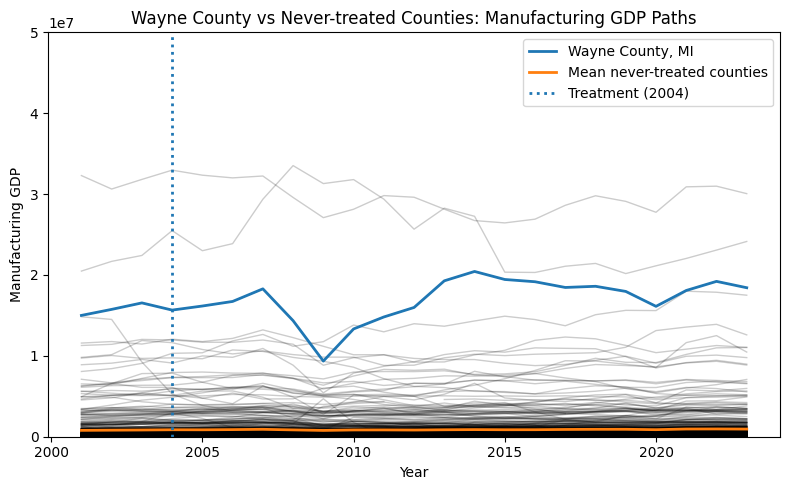

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


for _, gdf in gdp_tc.groupby("GeoFIPS"):
    ax.plot(gdf["year"], gdf["Manufacturing"], alpha=0.2, lw=1, color="k")


wayne = gdp_tc[gdp_tc["GeoName"] == "Wayne, MI"]
ax.plot(
    wayne["year"],
    wayne["Manufacturing"],
    label="Wayne County, MI",
    lw=2
)

(
    gdp_tc[gdp_tc["never_treated"] == 1]
    .groupby("year")["Manufacturing"]
    .mean()
    .plot(ax=ax, label="Mean never-treated counties", lw=2)
)

ax.set_ylim(0, 0.5e8)

plt.vlines(
    x=2004,
    ymin=0,
    ymax=2e8,
    linestyle=":",
    lw=2,
    label="Treatment (2004)"
)

ax.set_ylabel("Manufacturing GDP")
ax.set_xlabel("Year")
ax.set_title("Wayne County vs Never-treated Counties: Manufacturing GDP Paths")
ax.legend()
plt.tight_layout()
plt.show()


In [25]:
gdp_tc.head()

,GeoFIPS,GeoName,year,Accommodation and food services,Administrative and support and waste management and remediation services,"Arts, entertainment, and recreation",Durable goods manufacturing,Educational services,Finance and insurance,Health care and social assistance,...,Natural resources and mining,Private goods-producing industries 2/,Private services-providing industries 3/,Trade,Transportation and utilities,never_treated,post,treated,p*t,pxt
0,17001,"Adams, IL",2001,75938.0,41317.0,14307.0,NaN,37444.0,208753.0,302920.0,...,56414.0,678000.0,1720207.0,384986.0,114206.0,1,0,0,0,0
1,17001,"Adams, IL",2002,76916.0,39250.0,14095.0,287831.0,36563.0,218324.0,307694.0,...,61074.0,683046.0,1774516.0,400504.0,110649.0,1,0,0,0,0
2,17001,"Adams, IL",2003,78555.0,41965.0,14338.0,321207.0,36054.0,210836.0,311495.0,...,169891.0,819746.0,1804058.0,436775.0,110224.0,1,0,0,0,0
3,17001,"Adams, IL",2004,81615.0,42776.0,15402.0,401105.0,36071.0,211241.0,327978.0,...,155235.0,892072.0,1843200.0,441866.0,109148.0,1,1,0,0,0
4,17001,"Adams, IL",2005,80280.0,42945.0,15221.0,443988.0,35280.0,215288.0,345654.0,...,113061.0,908185.0,1897747.0,454732.0,113808.0,1,1,0,0,0


## TWFE Model

In [31]:
model_df = gdp_tc[['gdp_all', 'pxt', 'year', 'GeoFIPS', "treated"]].dropna().copy()

model_df['GeoFIPS'] = model_df['GeoFIPS'].astype(str).astype('category')

res = pf.feols('gdp_all ~ pxt | year + GeoFIPS', data=model_df)

res.summary()

ValueError: Demeaning failed after 100000 iterations.

## Synthetic Control (Need fixes)

In [6]:
treat_year = 2004
features = ["gdp_all", "Manufacturing"]  

inverted = (
    gdp_tc.query("year < @treat_year")      
          .pivot(index="GeoName", columns="year")[features]  
          .T                               
)

inverted

GeoName             Adams, IL  Adams, IN  Adams, OH  Adams, PA  Adams, WI  \
              year                                                          
gdp_all       2001  2729402.0  1166523.0  1471370.0  2870686.0   506199.0   
              2002  2793895.0  1249081.0  1459010.0  3079556.0   587318.0   
              2003  2959431.0  1300689.0  1426564.0  3077669.0   576008.0   
Manufacturing 2001   449386.0   485434.0    65477.0   649619.0    41579.0   
              2002   450226.0   556985.0    55587.0   651855.0    47565.0   
              2003   493972.0   564967.0    59041.0   690227.0    49743.0   

GeoName             Albany, NY  Alcona, MI  Alexander, IL  Alger, MI  \
              year                                                     
gdp_all       2001  25619736.0    215593.0       193045.0   300415.0   
              2002  25559345.0    224256.0       192459.0   304621.0   
              2003  26341642.0    230559.0       190301.0   299096.0   
Manufacturing 2001   1019314.0     13262.0        20467.0    60807.0   
              2002   1022457.0     13135.0        16557.0    70134.0   
              2003   1059049.0     13585.0        17947.0    69025.0   

GeoName             Allegan, MI  ...  Williamson, IL  Winnebago, IL  \
              year               ...                                  
gdp_all       2001    3761169.0  ...       2055676.0     12821755.0   
              2002    3821024.0  ...       2154247.0     13005161.0   
              2003    3979730.0  ...       2204374.0     13279150.0   
Manufacturing 2001    1584848.0  ...        165214.0      3338137.0   
              2002    1562126.0  ...        198284.0      3238274.0   
              2003    1537961.0  ...        221250.0      3363332.0   

GeoName             Winnebago, WI  Wirt, WV   Wood, WI  Woodford, IL  \
              year                                                     
gdp_all       2001      8510486.0   73508.0  3618877.0      940218.0   
              2002      9147946.0   74405.0  3740371.0      981887.0   
              2003      9222775.0   72532.0  3874014.0     1011955.0   
Manufacturing 2001      2927229.0       NaN   903025.0      181912.0   
              2002      3297354.0       NaN   935410.0      175110.0   
              2003      3143452.0       NaN   886592.0      176406.0   

GeoName             Wyandot, OH  Wyoming, NY  Wyoming, WV  Yates, NY  
              year                                                    
gdp_all       2001     885309.0    1208423.0     668623.0   726941.0  
              2002    1000566.0    1300099.0     674658.0   781146.0  
              2003    1102747.0    1378078.0     626175.0   772719.0  
Manufacturing 2001     302564.0     155553.0      13823.0    92125.0  
              2002     348896.0     171661.0      14452.0   104624.0  
              2003     384500.0     172556.0      22790.0    93411.0  

[6 rows x 557 columns]

In [7]:
# treated unit = Wayne, MI
X1 = inverted["Wayne, MI"].values               

donor_names = [c for c in inverted.columns if c != "Wayne, MI"]
X0 = inverted[donor_names].values              


def loss_w(W, X0, X1) -> float:
    return np.sqrt(np.mean((X1 - X0.dot(W))**2))


def get_w(X0, X1):
    w_start = [1 / X0.shape[1]] * X0.shape[1]   
    weights = fmin_slsqp(
        partial(loss_w, X0=X0, X1=X1),
        np.array(w_start),
        f_eqcons=lambda x: np.sum(x) - 1,      
        bounds=[(0.0, 1.0)] * len(w_start),    
        disp=False
    )
    return weights

wayne_weights = get_w(X0, X1)


wayne_weights_series = pd.Series(wayne_weights, index=donor_names, name="weight")
print(wayne_weights_series.sort_values(ascending=False))


Adams, IL       0.001799
Montcalm, MI    0.001799
Monroe, IN      0.001799
Monroe, NY      0.001799
Monroe, OH      0.001799
                  ...   
Fulton, NY      0.001799
Fulton, IN      0.001799
Fulton, IL      0.001799
Franklin, PA    0.001799
Yates, NY       0.001799
Name: weight, Length: 556, dtype: float64


In [8]:
donor_panel = (
    gdp_tc.query('GeoName != "Wayne, MI"')
          .pivot(index="year", columns="GeoName")["gdp_all"]
          .sort_index()
)

donor_panel = donor_panel[donor_names]

wayne_synth = donor_panel.values.dot(wayne_weights)

wayne_actual = (
    gdp_tc[gdp_tc["GeoName"] == "Wayne, MI"]
    .sort_values("year")
    .set_index("year")["gdp_all"]
)

years = donor_panel.index  


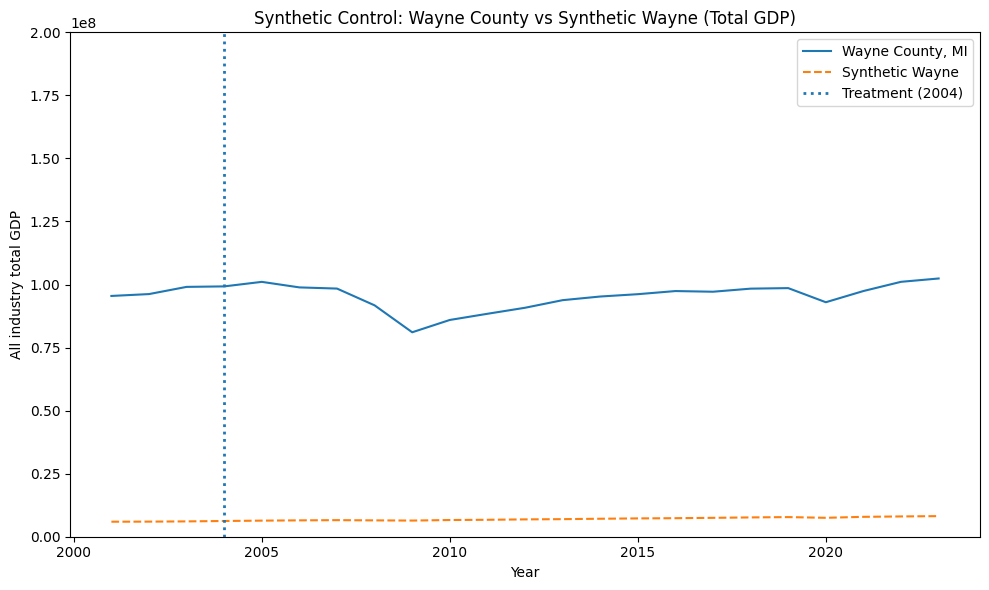

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(wayne_actual.index, wayne_actual.values, label="Wayne County, MI")
plt.plot(years, wayne_synth, label="Synthetic Wayne", linestyle="--")

plt.vlines(x=treat_year, ymin=0, ymax=2e8, linestyle=":", lw=2, label="Treatment (2004)")
plt.ylim(0, 2e8)

plt.ylabel("All industry total GDP")
plt.xlabel("Year")
plt.title("Synthetic Control: Wayne County vs Synthetic Wayne (Total GDP)")
plt.legend()
plt.tight_layout()
plt.show()
